### Feature Engineering

We will work on the logarithmic of migration data. As regards inputs, we consider their log-transforms for inputs that have positive values only. We  keep the intercept, to consider the "independent" flow of migration, i.e. not related to other variables.

In [172]:
data = data_set_cut.drop('Country',axis=1).drop('Emigration, % pop',axis=1)


We transform both input and output as below:
* Output $y = log_{10} (E)$
* Input with values in $R^+$: $x_i = log_{10} (I_i)$ (multiplicative factors)
* Input with values in $R$ : $x_i = I_i$ (additive factors)


so that the model that we identify, here below: 

---
$y = \alpha_0 + \alpha_1 \cdot x_1 + \alpha_2 \cdot x_2 + \alpha_3 \cdot x_3  \ldots$   (multiplicative factors)



$\ldots \alpha_4 x_4 + \alpha_5 x_5$ (additive factors)


is equivalent to

---
$exp (E) = exp( \alpha_0  + \alpha_1 \log {I_1} + \alpha_2 \log {I_2} + \alpha_3 \log {I_3} + \ldots$ 

$\ldots + \alpha_4 I_4 + \alpha_5 I_5)$



hence to a multiplicative model, as below

___
$E = e ^{\alpha_0} \cdot {I_1}^{\alpha_1}\cdot {I_2}^{\alpha_2}\cdot {I_3}^{\alpha_3} \cdot \ldots$

$\ldots \cdot \exp (I_4)^{\alpha_4} \cdot  \exp(I_5)^{\alpha_5} $



In [173]:
data_corrected = pd.DataFrame()
for column in data:
    if all(data[column]>0):
        data_corrected['Log of '+column] = data[column].apply(np.log10)
    else:
        data_corrected[column] = data[column]

### Model Identification

In [174]:
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,robust_scale


In [175]:
def sel_regressor(df,col_target):
    """Given a dataframe and the target column, create matrix of regressors X and target y"""
    
    y = df[col_target].values.astype(float)
    X = df.drop(col_target,axis=1).values.astype(float)
    input_name = df.drop(col_target,axis=1).columns
    return X,y, input_name

In [177]:
X_temp,y,input_name = sel_regressor(data_corrected,'Log of Emigration, total')


In [178]:
# Preprocessing X,y

Standardize the dataset 

In [179]:
# X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.3)

In [205]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled_minmax = scaler.fit_transform(X_temp)
X_scaled_rob = robust_scale(X_temp)

In [206]:
X = X_scaled_rob
model_lasso.fit(X_scaled_rob,y)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.005, fit_intercept=True,
    max_iter=100000000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

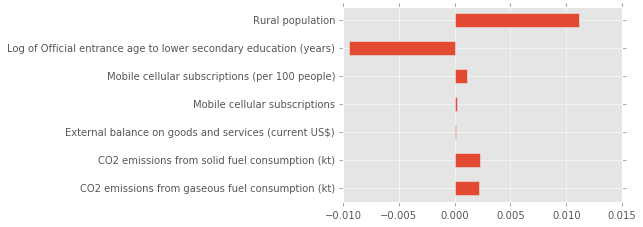

In [209]:
all_lasso_coeff = pd.Series(model_lasso.coef_,index =input_name)
lasso_coeff = all_lasso_coeff[all_lasso_coeff!=0]
plt.figure(figsize=(5,len(lasso_coeff)/2))
lasso_coeff.plot(kind='barh')

## Model

In [204]:
model_lasso = LassoCV(0.005,max_iter=100000000)

### Model shape

In [210]:
print ('Relative Emigration (% pop)= ')
print(10**model_lasso.intercept_)

for par, coeff in lasso_coeff.iteritems():
    print ('* ')
    if par[0:3]=='Log':
        print (str(par[7:]) +' ^ ' + str(coeff))
    else:
        print('exp ( '+par+' * '+str(coeff)+')')


Relative Emigration (% pop)= 
169661.9478797082
* 
exp ( CO2 emissions from gaseous fuel consumption (kt) * 0.0022112548290910573)
* 
exp ( CO2 emissions from solid fuel consumption (kt) * 0.002236439808560992)
* 
exp ( External balance on goods and services (current US$) * 9.989600640373783e-05)
* 
exp ( Mobile cellular subscriptions * 0.00018447875366446446)
* 
exp ( Mobile cellular subscriptions (per 100 people) * 0.0011281917185128449)
* 
Official entrance age to lower secondary education (years) ^ -0.009473672981408006
* 
exp ( Rural population * 0.011166848895557004)


--- 
[How to interpret parameters:]

In [211]:
par_lasso = model_lasso.get_params()
# plt.bar(range(len(model_lasso.alphas_)),height=model_lasso.alphas_)
par_lasso

{'alphas': None,
 'copy_X': True,
 'cv': None,
 'eps': 0.005,
 'fit_intercept': True,
 'max_iter': 100000000,
 'n_alphas': 100,
 'n_jobs': 1,
 'normalize': False,
 'positive': False,
 'precompute': 'auto',
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'verbose': False}

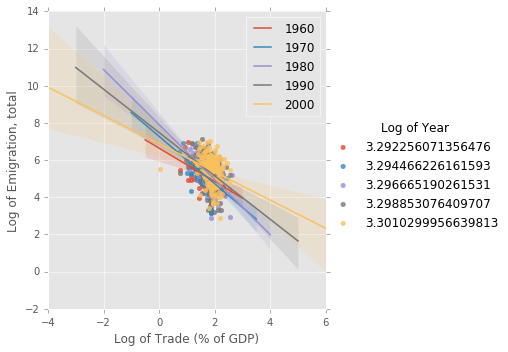

In [219]:
plt.figure(figsize=(10,8))
sns.lmplot(data=data_corrected,x='Log of Trade (% of GDP)',y='Log of Emigration, total', hue='Log of Year')
plt.legend(['1960','1970','1980','1990','2000'])
#plt.xlim([1,3.5])
#plt.ylim([-1,2])

### Predict

In [220]:
y_pred = model_lasso.predict(X)

#### Model error

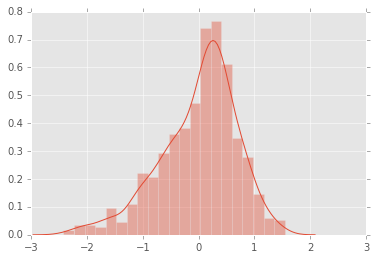

In [221]:
err = y - y_pred
sns.distplot(err)

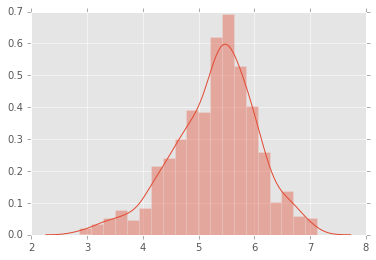

In [222]:
sns.distplot(y)

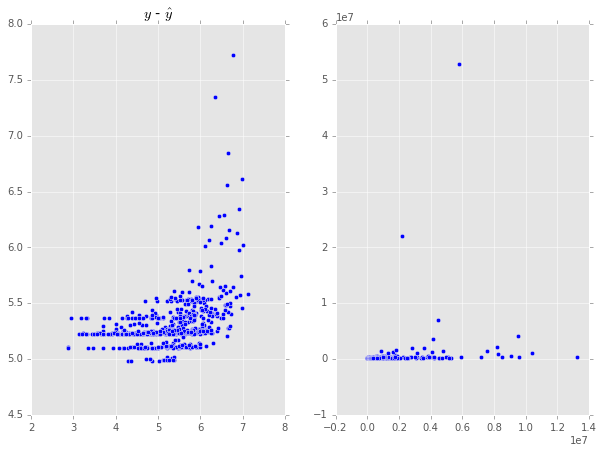

In [223]:
plt.figure(figsize=(10,7))
plt.subplot(121)
plt.scatter(y, y_pred)
plt.title('$y$ - $\hat{y}$')
plt.subplot(122)
plt.scatter(10**(y), 10**(y_pred))

##### Model score

In [224]:
model_lasso.score(X,y)

0.15643047302885738